# Toxic Data Detection Using Bert and Topic Modelling

## Prepare the environment

Load the libraries neessary for setting up the environment and load the data from hugging face. The data will be limited to 50% for this notebook as there is insufficient memory for loadin the entire dataset in Google Colab.

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from pyspark.sql import SparkSession


In [ ]:
spark = SparkSession.builder.appName("RedditFlatten").getOrCreate()

In [ ]:
from datasets import load_dataset

ds = load_dataset("nreimers/reddit_question_best_answers", split="train", streaming=True)

data = [sample for sample in ds.take(50000)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/298 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/138 [00:00<?, ?it/s]

## EDA

In [ ]:
df = spark.createDataFrame(data)

In [ ]:
data = None
ds = None
df.show(5)

+--------------------+--------------------+-----+--------------------+
|             answers|                body|score|               title|
+--------------------+--------------------+-----+--------------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|
|[{body -> [Who's ...|I'm thinking of s...|    6|Suggest some blac...|
+--------------------+--------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
rows = df.count()
columns = len(df.columns)
print ('Rows: ', rows)
print ('Columns: ', columns)

Rows:  50000
Columns:  4


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql import types as T

def extract_answer_body(copy_text):
  thread = ''
  for o in copy_text:
    if thread == '':
      thread = o['body']
    else:
      thread = ' '.join([thread, o['body']])

  data = None
  return thread

eab_udf = f.udf(extract_answer_body, T.StringType())

In [ ]:
def extract_answer_body(copy_text):
  thread = ''
  for o in copy_text:
    if thread == '':
      thread = o['body']
    else:
      thread = ' '.join([thread, o['body']])

  data = None
  return thread

eab_udf = f.udf(extract_answer_body, T.StringType())

In [ ]:
df = df.withColumn('combined_answers', eab_udf(f.col('answers')))

In [ ]:
working_df = df.withColumn('thread', f.concat_ws(' ', f.col('title'), f.col('body'), f.col('combined_answers')))

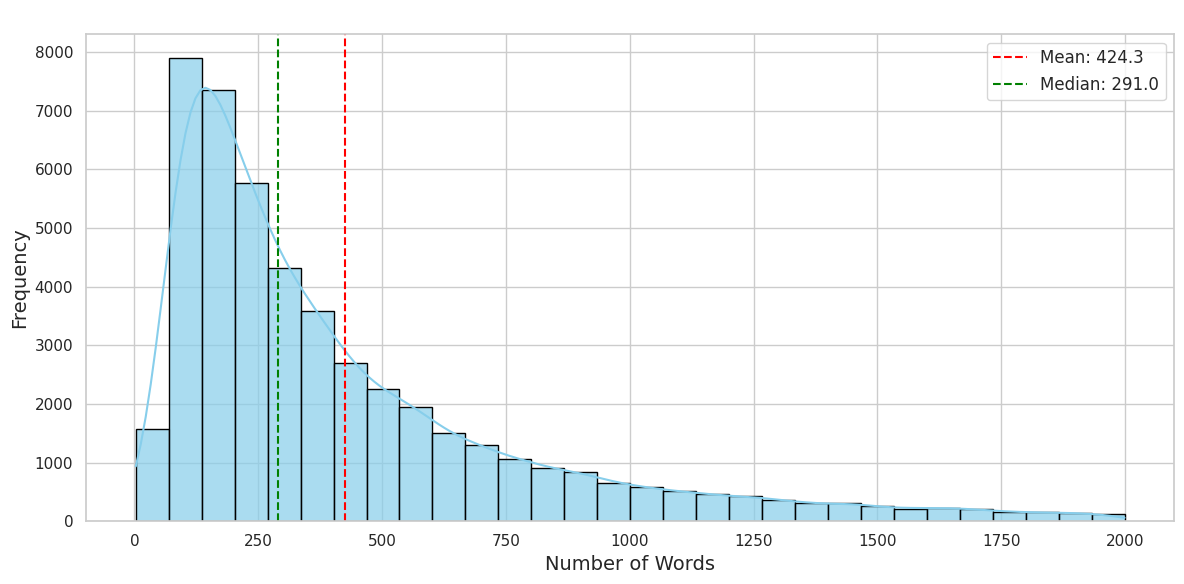

In [ ]:
from pyspark.sql.functions import split, size, col
import seaborn as sns
import matplotlib.pyplot as plt

working_df = working_df.withColumn("thread_length", size(split(col("thread"), " ")))

text_lengths = working_df.select("thread_length").rdd.flatMap(lambda x: x).collect()
filtered_lengths = [x for x in text_lengths if x < 2000]

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(filtered_lengths, kde=True, bins=30, color="skyblue", edgecolor="black", alpha=0.7)

# mean and median
mean_length = sum(filtered_lengths) / len(filtered_lengths)
median_length = sorted(filtered_lengths)[len(filtered_lengths) // 2]
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')


plt.title(" ", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
summary_stats = working_df.select("thread_length").rdd.map(lambda row: row[0]).stats()
min_length = summary_stats.min()
max_length = summary_stats.max()

# Compute 25th, 50th, and 75th percentiles using approxQuantile
percentiles = working_df.select("thread_length").approxQuantile("thread_length", [0.25, 0.5, 0.75], 0.01)

# Unpack the percentiles
percentile_25, median, percentile_75 = percentiles

In [ ]:
print(f"Min Length: {min_length}")
print(f"Max Length: {max_length}")
print(f"25th Percentile: {percentile_25}")
print(f"50th Percentile (Median): {median}")
print(f"75th Percentile: {percentile_75}")

Min Length: 3.0
Max Length: 97156.0
25th Percentile: 162.0
50th Percentile (Median): 302.0
75th Percentile: 592.0


In [ ]:
text_lengths = None
filtered_lengths = None

### Tokenize data

In [ ]:
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import numpy as np
import nltk
import re
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

# combine stop words
spacy_stop_words = nlp.Defaults.stop_words
nltk_stop_words = set(stopwords.words('english'))
sklearn_stop_words = ENGLISH_STOP_WORDS
combined_stop_words = set(spacy_stop_words).union(nltk_stop_words, sklearn_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_urls(text):
    """Remove URLs from text."""
    return re.sub(r"http[s]?://\S+|www\.\S+", "", text)

def generate_word_tokens(stop_words):
    data = np.array(df.select('body').collect())
    word_tokens = []

    for body in data:
        for content in body:
            # Remove URLs
            content = remove_urls(content)

            # Tokenize words
            words = word_tokenize(content)

            # Process words: lowercase, remove punctuation/non-alphabetic, filter stop words
            processed_words = [
                word.lower() for word in words
                if word.lower() not in stop_words and
                word.isalpha()  # Keeps only alphabetic words
            ]

            word_tokens += processed_words
            words = None
    data = None
    return word_tokens

In [ ]:
word_tokens = generate_word_tokens(combined_stop_words)

In [ ]:
print(word_tokens[:50])

['dollhouse', 'drawing', 'close', 'need', 'new', 'tv', 'watch', 'figured', 'older', 'series', 'missed', 'current', 'series', 'gotten', 'check', 'list', 'suggestions', 'read', 'gim', 'ideas', 'currently', 'watching', 'dollhouse', 'lost', 'flashforward', 'v', 'true', 'blood', 'smallville', 'previously', 'watched', 'stargate', 'sure', 'missed', 'couple', 'seasons', 'buffy', 'angel', 'prolly', 'watch', 'rest', 'alias', 'seen', 'star', 'trek', 'tng', 'voyager', 'bit', 'enterprise', 'babylon']


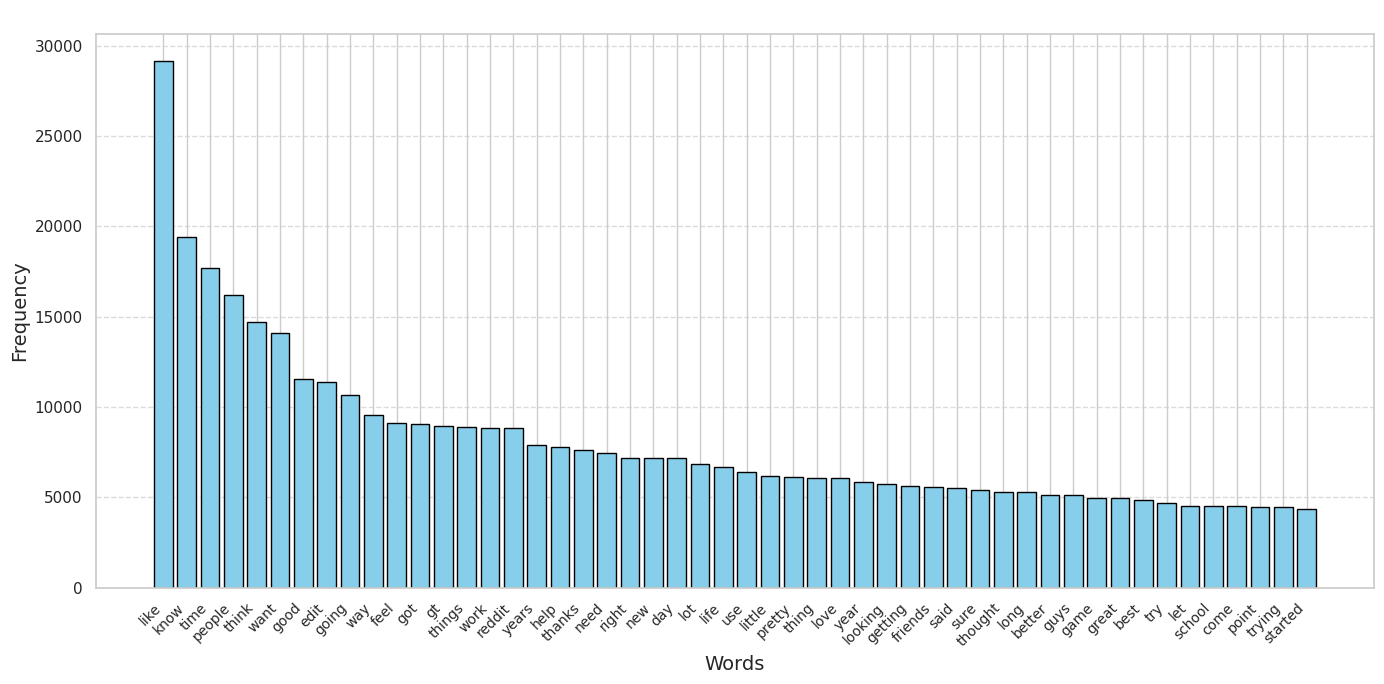

In [ ]:
from collections import Counter

word_freq = Counter(word_tokens)

# Get the 50 most common words
most_common_words = word_freq.most_common(50)

# Separate words and their counts for plotting
words = [item[0] for item in most_common_words]
counts = [item[1] for item in most_common_words]

# Visualization
plt.figure(figsize=(14, 7))
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(" ", fontsize=16, fontweight='bold')
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
most_common_count = sum(freq for _, freq in most_common_words)
total_words = len(word_tokens)
most_common_proportion = (most_common_count / total_words * 100) if total_words > 0 else 0

print(most_common_count)
print(total_words)
print(most_common_proportion)

405539
2719348
14.913096815854388


In [ ]:
spacy_stop_words = None
nltk_stop_words = None
sklearn_stop_words  = None
counts = None
ENGLISH_STOP_WORDS = None
most_common_words = None
word_tokens = None

In [ ]:
other_stop_words = ['the', 'to', 'and', 'a', 'of', 'that', 'in', 'on', 'with',
                    'but', 'or', 'if', 'from', 'http', 'www', 'imgur', 'jpg', 'gt', 'com', 'amp']
custom_stop_words = combined_stop_words.union(set(other_stop_words))

In [ ]:
freq_dist = None
# word_tokens = None

In [ ]:
def generate_clean_corpus(stop_words):
    data = np.array(df.select('body').collect())
    word_tokens = []

    for body in data:
        for content in body:
            # Remove URLs
            content = remove_urls(content)

            # Tokenize words
            words = word_tokenize(content)

            # Process words: lowercase, remove punctuation/non-alphabetic, filter stop words,
            # length > 3
            processed_words = [
                word.lower() for word in words
                if word.lower() not in stop_words and
                   word.isalpha() and  # Ensures the word is alphabetic
                   len(word) > 3  # Keeps words longer than 3 characters
            ]

            word_tokens += processed_words
            words = None
    data = None

    # Join the word tokens into a single string
    clean_corpus = ' '.join(word_tokens)

    return clean_corpus

In [ ]:
corpus = generate_clean_corpus(custom_stop_words)

In [ ]:
type(corpus)

str

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

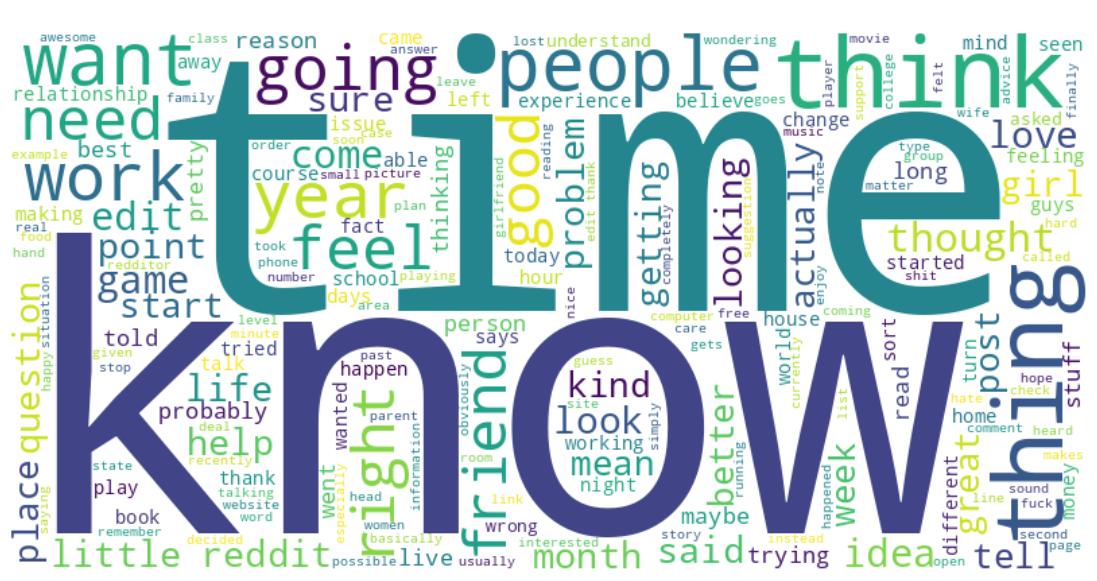

In [ ]:
from wordcloud import WordCloud

word_cloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

# Display the word cloud
plt.figure(figsize=(14, 7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title(" ")
plt.axis('off')
plt.show()

In [ ]:
word_tokens = corpus.split()
corpus_length = len(word_tokens)
unique_words = len(set(word_tokens))
unique_word_percentage = (unique_words / corpus_length * 100) if corpus_length > 0 else 0

print(corpus_length)
print(unique_words)
print(unique_word_percentage)

2460750
75219
3.0567509905516608


In [ ]:
word_tokens = None
corpus = None

## Combine the df

In [ ]:
from pyspark.sql import functions as f
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline

In [ ]:
working_df = df.withColumn('cleaned_body', f.concat_ws(' ', f.col('title'), f.col('body')))\
  .withColumn('cleaned_body', f.regexp_replace(f.col('cleaned_body'), '[^\w\s]', ' '))\
  .withColumn('cleaned_body', f.regexp_replace(f.col('cleaned_body'), '[0-9]', ''))\
  .withColumn('cleaned_body', f.regexp_replace(f.col('cleaned_body'), '\\s+', ' '))

In [ ]:
# We can eliminat the need for df as we will continue working with the working_df
df = None

In [ ]:
working_df.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|             answers|                body|score|               title|    combined_answers|        cleaned_body|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|Have you seen [Th...|Sci fi ish tv ser...|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|F*ck the glossary...|For those who ve ...|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|Just be sure to c...|Want to effect ch...|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|Hanging out with ...|I ve lost my abil...|
|[{body -> [Who's ...|I'm thinking of s...|    6|Suggest some blac...|[Who's Hungry](ht...|Suggest some blac...|
+--------------------+--------------------+-----+--------------------+--------------------+-----

In [ ]:
def extract_answer_body(copy_text):
  thread = ''
  for o in copy_text:
    if thread == '':
      thread = o['body']
    else:
      thread = ' '.join([thread, o['body']])

  data = None
  return thread

eab_udf = f.udf(extract_answer_body, T.StringType())

In [ ]:
working_df = working_df.withColumn('combined_answers', eab_udf(f.col('answers')))

In [ ]:
working_df.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|             answers|                body|score|               title|    combined_answers|        cleaned_body|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|Have you seen [Th...|Sci fi ish tv ser...|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|F*ck the glossary...|For those who ve ...|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|Just be sure to c...|Want to effect ch...|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|Hanging out with ...|I ve lost my abil...|
|[{body -> [Who's ...|I'm thinking of s...|    6|Suggest some blac...|[Who's Hungry](ht...|Suggest some blac...|
+--------------------+--------------------+-----+--------------------+--------------------+-----

In [ ]:
from pyspark.sql.functions import regexp_replace, col, concat_ws, trim

working_df = working_df.withColumn(
    'cleaned_threads',
    concat_ws(' ', col('title'), col('body'), col('combined_answers'))
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '[^\w\s]', ' ')  # Remove non-alphanumeric characters
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '[0-9]', '')  # Remove digits
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '\\bhttp\\S+|www\\S+', '')  # Remove URLs
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '\\b\\w{1}\\b', '')  # Remove tokens with less than 2 characters
).withColumn(
    'cleaned_threads', regexp_replace(col('cleaned_threads'), '\\s+', ' ')  # Replace multiple spaces with single space
).withColumn(
    'cleaned_threads', trim(col('cleaned_threads'))  # Trim leading and trailing spaces
)

In [ ]:
working_df.show(5)

+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|             answers|                body|score|               title|    combined_answers|        cleaned_body|     cleaned_threads|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|Have you seen [Th...|Sci fi ish tv ser...|Sci fi ish tv ser...|
|[{body -> F*ck th...|How do you get th...|   20|For those who've ...|F*ck the glossary...|For those who ve ...|For those who ve ...|
|[{body -> Just be...|There's been a li...|   70|Want to effect ch...|Just be sure to c...|Want to effect ch...|Want to effect ch...|
|[{body -> Hanging...|When I was a youn...|   16|I've lost my abil...|Hanging out with ...|I ve lost my abil...|ve lost my abilit...|
|[{body -> [Who's ...|I'm thinking of s...|    6|Suggest some 

### Topic modeling

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

working_df = working_df.withColumn("index", monotonically_increasing_id())

In [ ]:
combined_stop_words = None
words = None

In [ ]:
# tokenize the text using the cleaned-up version
tokenize = Tokenizer(inputCol = 'cleaned_threads',
                      outputCol = 'words')

# remove stop words
custom_stop_words = list(custom_stop_words)
remove_sw = StopWordsRemover(inputCol = 'words',
                             outputCol = 'filtered', stopWords=custom_stop_words)

# count vectorizer
cv = CountVectorizer(inputCol = 'filtered',
                     outputCol = 'counts' ,
                     vocabSize = 20000,
                     minDF = 5)

# compute the inverse document frequency
idf = IDF(inputCol = 'counts',
          outputCol = 'idf')

# create a pipeline and transform the articles data frame
pipeline = Pipeline() \
     .setStages([tokenize,
                 remove_sw,
                 cv,
                 idf])

pipeline_model = pipeline.fit(working_df)

processed_df= pipeline_model\
  .transform(working_df)

# processed_df\
#   .select('cleaned_threads', 'idf')\
#   .show(5, truncate = False)

In [ ]:
lda = LDA(k=20, featuresCol='idf', maxIter=10)
lda_model = lda.fit(processed_df)

topics = lda_model.describeTopics(15)
# topics.show(truncate = False)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Get the vocabulary from the CountVectorizer model
cv_model = pipeline_model.stages[2]
vocabulary = cv_model.vocabulary

In [ ]:
def map_indices_to_words(indices):
    return [vocabulary[idx] for idx in indices[:5]]  # Limit to top 5 words

# Update the topic_words_dict to include only top 5 words per topic
topics = lda_model.describeTopics(15)
topic_words_dict = {
    row['topic']: map_indices_to_words(row['termIndices'])
    for row in topics.collect()
}

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def get_top_words(topic_distribution):
    most_probable_topic = max(enumerate(topic_distribution), key=lambda x: x[1])[0]
    return ' '.join(topic_words_dict.get(most_probable_topic, []))

get_top_words_udf = udf(get_top_words, StringType())

In [ ]:
# Transform the processed_df to get topic distributions
document_topics = lda_model.transform(processed_df)

# Add the top words column to the original DataFrame
working_df_with_topics = working_df.join(
    document_topics.select('topicDistribution', 'index'),
    on='index'
).withColumn('top_words', get_top_words_udf(col('topicDistribution')))

In [ ]:
# working_df_with_topics.show(5)

In [ ]:
working_df_with_topics_ordered = working_df_with_topics.orderBy(col("score").desc())

working_df_with_topics_ordered.select("title", "score", "top_words").show(truncate=False, n=10)

+--------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------+
|title                                                                                                                                 |score|top_words                              |
+--------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------+
|The health bill has PASSED!                                                                                                           |7249 |government tax taxes party country     |
|Reddit, I've been promising this to you for months, and it's finally ready. I hope you like it.                                       |4984 |linux windows use file software        |
|America, we need a third party that can galvanize our generation. One that doesn't r

In [ ]:
vocabulary = None
working_df = None

# Toxic Bert

In [ ]:
pip install torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def calculate_toxicity(batch_text):
    # Tokenize the batch of text
    inputs = tokenizer(batch_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Return toxicity probabilities (assume label 1 corresponds to "toxic")
    val =  [float(prob[1]) for prob in probs]
    return val[0]

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, ArrayType, StringType

# Define a UDF to calculate toxicity score
def get_toxicity_udf(text):
    try:
        score = calculate_toxicity([text])  # Process single row as a batch
        return score[0]
    except Exception as e:
        return float('nan')  # Handle errors gracefully

toxicity_udf = udf(get_toxicity_udf, FloatType())

In [ ]:
# toxicity_scores = working_df_with_topics.select(
#      toxicity_udf(col("title").alias('toxicityscore'))
# )

In [ ]:
# from pyspark.sql.functions import row_number,lit
# from pyspark.sql.window import Window

# w = Window().orderBy(lit('A'))
# working_df_with_topics = working_df_with_topics.withColumn('id', f.row_number().over(w))


In [ ]:
working_df_with_topics.show(5)

+-----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|             answers|                body|score|               title|    combined_answers|        cleaned_body|     cleaned_threads|   topicDistribution|           top_words|
+-----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|[{body -> Have yo...|With Dollhouse dr...|   17|Sci-fi (-ish) tv ...|Have you seen [Th...|Sci fi ish tv ser...|Sci fi ish tv ser...|[0.02635163770998...|books game series...|
|    6|[{body -> As a Go...|I'm in Australia ...|  228|At 11.19 a.m toda...|As a Google emplo...|At a m today be p...|At today be prepa...|[4.34318856723272...|relationship girl...|
|    7|[{body -> Go to S...|The major perpetr...|    3|My Powerbook has ...|Go to Safari -

In [ ]:
toxicity_data = working_df_with_topics.select('title', 'score', 'top_words', 'cleaned_threads').toPandas()

In [ ]:
toxicity_data.to_csv('toxicity_data.csv')

In [ ]:
# toxicity_data['toxic_score'] = toxicity_data['cleaned_threads'].apply(calculate_toxicity)

In [ ]:
# toxicity_data.head()

In [ ]:
# Cache the dataset
# working_df_with_topics.sort_values('toxic_score', ascending=False).head()

## Resume calculation of toxicity scores

This section of code assumes the toxicity_data.csv is present on ones's google drive.

In [ ]:
pip install torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def calculate_toxicity(batch_text):
    # Tokenize the batch of text
    inputs = tokenizer(batch_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Return toxicity probabilities (assume label 1 corresponds to "toxic")
    val =  [float(prob[1]) for prob in probs]
    return val[0]

In [ ]:
def measure_toxicity(input_text):
    """
    Measures the toxicity of the input text using the unitary/toxic-bert model.

    Args:
        input_text (str): The text to analyze.

    Returns:
        float: Toxicity probability (range 0 to 1).
    """
    # Tokenize and encode the input text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()

    # Return the toxicity score (second class probability)
    return float(probabilities[0][1])

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
toxicity_data = pd.read_csv('/content/drive/MyDrive/toxicity_data.csv')

In [ ]:
toxicity_data.columns

Index(['Unnamed: 0', 'title', 'score', 'top_words', 'cleaned_threads'], dtype='object')

In [ ]:
toxicity_data = toxicity_data.drop(['Unnamed: 0', 'top_words'], axis=1)

In [ ]:
toxicity_data.columns

Index(['title', 'score', 'cleaned_threads'], dtype='object')

In [ ]:
import csv

with open('/content/drive/MyDrive/toxicity_data_score.csv', 'w', newline='') as csvfile:
    fieldnames = ['title', 'score', 'toxicity_score']
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(fieldnames)
    for index, row in toxicity_data.iterrows():
      toxicity_score = measure_toxicity(row['cleaned_threads'])
      data = [row['title'], row['score'], toxicity_score]
      writer.writerow(data)

## Toxic Bert data Analysis

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
toxicity_scores = pd.read_csv('/content/drive/MyDrive/toxicity_data_score.csv')

In [ ]:
toxicity_scores.head()

,title,score,toxicity_score
0,Sci-fi (-ish) tv series that I might like and ...,17,0.008429
1,For those who've read A Clockwork Orange...,20,0.068873
2,Hi r/Islam! I have a question...,16,0.019428
3,"At 11.19 a.m today, be prepared to fight for h...",228,0.005105
4,My Powerbook has slowed way down. What should ...,3,0.007406


### Descriptive Statistics

In [ ]:
toxicity_scores.describe()

,score,toxicity_score
count,22903.000000,22903.000000
mean,34.005632,0.020600
std,137.264480,0.023455
min,3.000000,0.000517
25%,6.000000,0.003977
50%,10.000000,0.008248
75%,21.000000,0.032279
max,7249.000000,0.101339


### Score

In [ ]:
toxicity_scores.loc[toxicity_scores['score'].idxmax()]

,13110
title,The health bill has PASSED!
score,7249
toxicity_score,0.005528


In [ ]:
toxicity_scores.loc[toxicity_scores['score'].idxmin()]

,4
title,My Powerbook has slowed way down. What should ...
score,3
toxicity_score,0.007406


### Toxicity Score

In [ ]:
toxicity_scores.loc[toxicity_scores['toxicity_score'].idxmax()]

,22240
title,Thank you to everyone who participated in my s...
score,16
toxicity_score,0.101339


In [ ]:
toxicity_scores.loc[toxicity_scores['toxicity_score'].idxmin()]

,11493
title,Give Me Something To Laugh About
score,5
toxicity_score,0.000517


### Correlation

In [ ]:
toxicity_scores['score'].corr(toxicity_scores['toxicity_score'])

-0.07321650256451263

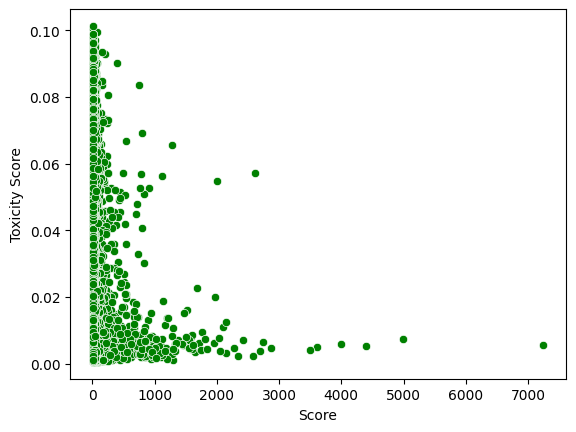

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create the scatter plot
sns.scatterplot(x='score', y='toxicity_score', data=toxicity_scores, color='green')

plt.xlabel('Score')
plt.ylabel('Toxicity Score')
# Show the plot
plt.show()

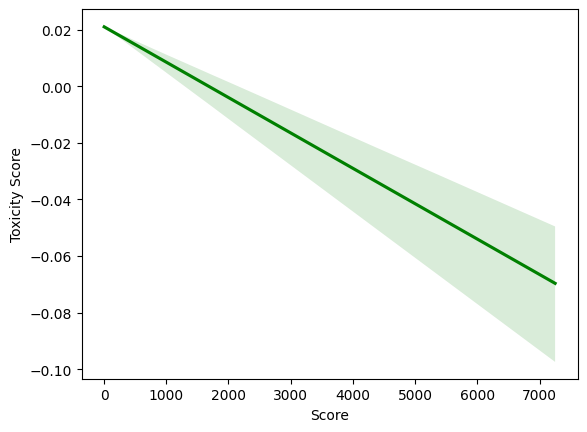

In [ ]:


# Fit a regression line
sns.regplot(x='score', y='toxicity_score', data=toxicity_scores, color='green', scatter=False)

plt.xlabel('Score')
plt.ylabel('Toxicity Score')
# Show the plot
plt.show()

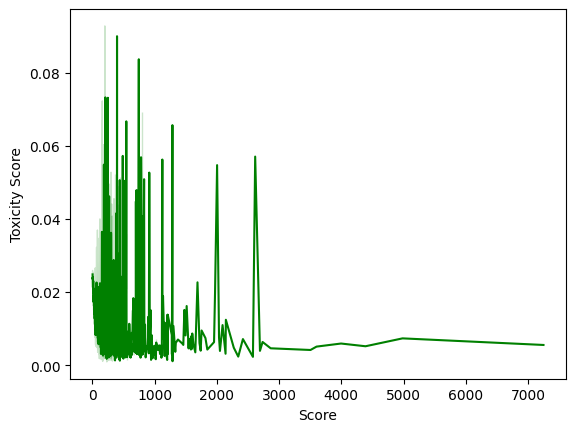

In [ ]:
# Fit a regression line
sns.lineplot(x='score', y='toxicity_score', data=toxicity_scores, color='green')

plt.xlabel('Score')
plt.ylabel('Toxicity Score')
# Show the plot
plt.show()